# Geospatial Visualization of the NYC Subway Network

## Data Visualization - Final Project
##### Rohan Kalyani

Paper Reproduce: *Examining the effect of land‑use function complementarity on intra‑urban spatial interactions using metro smart card records*

Ren et. al.

*Transportation* August 2020

https://www.researchgate.net/publication/330629780_Examining_the_effect_of_land-use_function_complementarity_on_intra-urban_spatial_interactions_using_metro_smart_card_records


Image to Reproduce

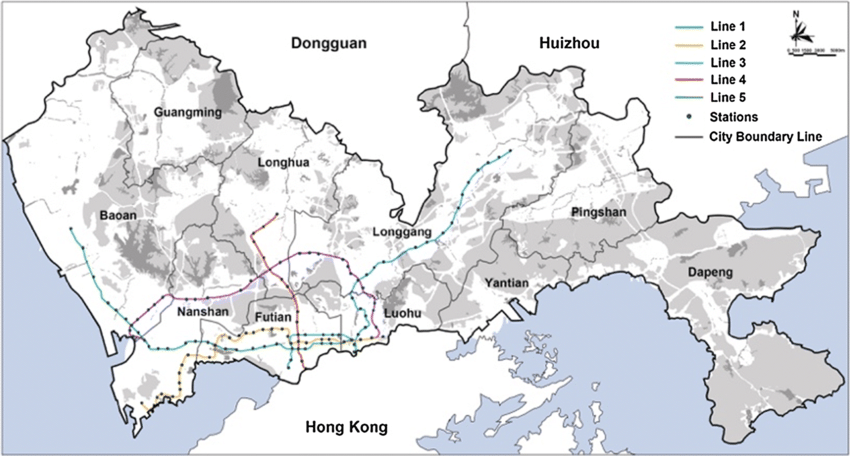

In [4]:
from IPython.display import Image
Image(filename='Metro-lines-in-Shenzhen.png')

### Network Construction

For the purposes of the Applied Data Science project that I made this network for (*Network Analysis and Ridership Projections for the Proposed Interborough Express Train in NYC*), the network is more complicated than just a list of all the subway stations as the nodes and the connections to other stations as the edges. To be specific, the network was meant to be used as a tool to project travel times between stations, taking into consideration train transfer times (i.e. time spent waiting for a train) as well as train speeds (i.e. time spent traveling on a train). To allow for this, on top of the original station nodes, platform nodes for each unique train line servicing a station as well as for each direction had to be made. New edges then connected platform nodes to other platform nodes, and platform nodes to their respective station nodes.

For the purposes of this data visualization project, the details of how exactly the nodes and edges were derived will be omitted, and the pre-processed list of nodes and edges from that process will be imported into this notebook. For a detailed breakdown of the process, please see the GitHub page for the full project, specifically the Network Processing notebooks:

https://github.com/CUSPADS2022IBX/IBXRidership/blob/main/Network%20Processing/subway_platform_network%20-%20noIBX.ipynb
https://github.com/CUSPADS2022IBX/IBXRidership/blob/main/Network%20Processing/subway_platform_network%20-%20wIBX.ipynb
https://github.com/CUSPADS2022IBX/IBXRidership

Import the list of edges and nodes needed to construct the network. Two sets: Current Network and Network w/ IBX Corridor Addition 

In [ ]:
import networkx as nx 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
%matplotlib inline 

In [7]:
nodes_now = pd.read_csv('nodes_no_ibx.csv', index_col=0)
nodes_ibx = pd.read_csv('nodes_ibx.csv', index_col=0)

edges_now = pd.read_csv('edges_no_ibx.csv', index_col=0)
edges_ibx = pd.read_csv('edges_ibx.csv', index_col=0)

Lets see what the networks look like without any flair. We'll use the raw lat/long data for the node positions.

In [8]:
nodePos_now = {nodes_now.node_id[c]: (nodes_now.long[c], nodes_now.lat[c]) for c in nodes_now.index}
nodePos_ibx = {nodes_ibx.node_id[c]: (nodes_ibx.long[c], nodes_ibx.lat[c]) for c in nodes_ibx.index}

Current Network

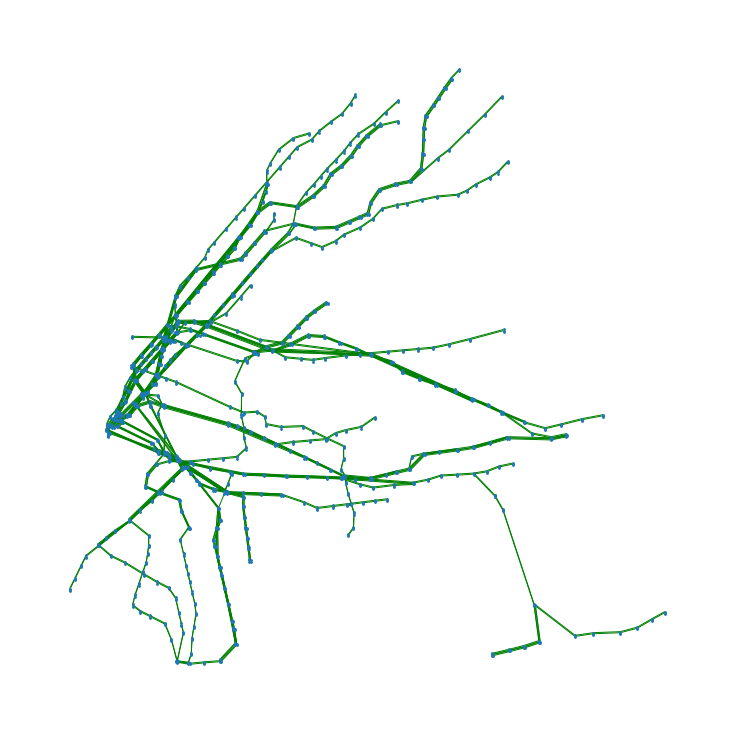

In [12]:
subway_now = nx.Graph()
for i in edges_now.index:
    subway_now.add_edge(edges_now.origin[i], edges_now.dest[i])

plt.figure(figsize = (10,10))
nx.draw(subway_now, pos = nodePos_now, node_size = 3, width = 1, edge_color = 'green')

Network w/ IBX

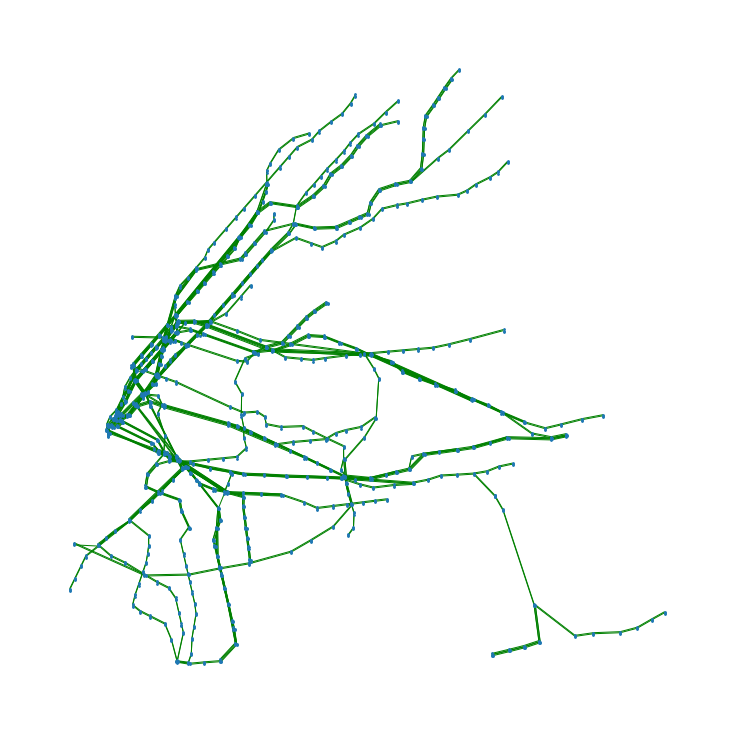

In [13]:
subway_ibx = nx.Graph()
for i in edges_ibx.index:
    subway_ibx.add_edge(edges_ibx.origin[i], edges_ibx.dest[i])

plt.figure(figsize = (10,10))
nx.draw(subway_ibx, pos = nodePos_ibx, node_size = 3, width = 1, edge_color = 'green')

### Geospatial Visualization

First define a colormap to color the edges depending on the train line that the edge represents. Can use the MTA's guide to color the lines as they appear on the official MTA subway map: http://web.mta.info/developers/resources/line_colors.htm

In [22]:
line_cmap_now = {
    'A': '#0039A6', 'C': '#0039A6', 'E': '#0039A6',
    'B': '#FF6319', 'D': '#FF6319', 'F': '#FF6319', 'M': '#FF6319',
    'G': '#6CBE45',
    'J': '#996633', 'Z': '#996633',
    'L': '#A7A9AC',
    'N': '#FCCC0A', 'Q': '#FCCC0A', 'R': '#FCCC0A', 'W': '#FCCC0A',
    'S': '#808183',
    '1': '#EE352E', '2': '#EE352E', '3': '#EE352E',
    '4': '#00933C', '5': '#00933C', '6': '#00933C',
    '7': '#B933AD',
    'complex': 'k', #station to station transfer edges colored black
    'station': 'k',
}

#add the colormapping as an edge attribute to the graph
subway_now = nx.Graph()
for i in edges_now.index:
    subway_now.add_edge(edges_now.origin[i], edges_now.dest[i], color = line_cmap_now.get(edges_now.line[i]))

#get arrray of colors for every edge in the graph
line_colors_now = nx.get_edge_attributes(subway_now, 'color').values()

In [23]:
line_cmap_ibx = {
    'A': '#0039A6', 'C': '#0039A6', 'E': '#0039A6',
    'B': '#FF6319', 'D': '#FF6319', 'F': '#FF6319', 'M': '#FF6319',
    'G': '#6CBE45',
    'J': '#996633', 'Z': '#996633',
    'L': '#A7A9AC',
    'N': '#FCCC0A', 'Q': '#FCCC0A', 'R': '#FCCC0A', 'W': '#FCCC0A',
    'S': '#808183',
    '1': '#EE352E', '2': '#EE352E', '3': '#EE352E',
    '4': '#00933C', '5': '#00933C', '6': '#00933C',
    '7': '#B933AD',
    'IBX': '#87CEEB', #assign the IBX a sky blue color
    'complex': 'k',
    'station': 'k',
}

#add the colormapping as an edge attribute
subway_ibx = nx.Graph()
for i in edges_ibx.index:
    subway_ibx.add_edge(edges_ibx.origin[i], edges_ibx.dest[i], color = line_cmap_ibx.get(edges_ibx.line[i]))

#get arrray of colors for every edge in the graph
line_colors_ibx = nx.get_edge_attributes(subway_ibx, 'color').values()

Next need to re-project the latitude and longittude of the nodes to a more NY-centered coordinate reference system: EPSG 32118

In [18]:
#transforms WGS 84 crs to more NY-centered CRS, EPSG:32118
def transform_crs(long, lat, in_crs = 4326, out_crs = 32118):
    from pyproj import Transformer

    proj = Transformer.from_crs(in_crs, out_crs, always_xy=True)

    return proj.transform(long, lat)

#transform geodetic lat/long to easting/northing for EPSG 32118 for all node locations
nodePos_proj_now={nodes_now.node_id[c]:transform_crs(nodes_now.long[c], nodes_now.lat[c]) for c in nodes_now.index}
nodePos_proj_ibx={nodes_ibx.node_id[c]:transform_crs(nodes_ibx.long[c], nodes_ibx.lat[c]) for c in nodes_ibx.index}

Now need to get a shapefile of NYC boroughs to use as a base object upon which the basemap and graph will be drawn upon.

In [21]:
#get shapefile for nyc boroughs and remove staten island. Source: NYC OpenData
boros = gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson')
boros = boros.loc[boros['boro_name'] != 'Staten Island']
boros_geo = gpd.GeoDataFrame(data = boros, geometry = 'geometry') #convert to GeoDataFrame
boros_geo = boros_geo.to_crs('epsg:32118')

Next, need to make a custom legend object using Matplotlib to show which color corresponds to which train service, with some additional visual flair.

In [26]:
#get a dataframe for the line colormapping to help make the legend
line_cmap_df_now = pd.DataFrame.from_dict(line_cmap_now, orient = 'index', columns = ['color']).reset_index()
line_cmap_df_now = line_cmap_df_now.groupby('color')['index'].apply(list) #group by color and list the corresponding train services 
line_cmap_df_now['k'] = ['Station', 'Transfer']
line_cmap_df_now = line_cmap_df_now.reindex(
    ['#0039A6', '#FF6319', '#6CBE45', '#A7A9AC', '#996633', '#FCCC0A', #change ordering of legend to match MTA's
    '#808183', '#EE352E', '#00933C', '#B933AD']
    )

#append legend handler objects and labels for every line
legend_lines_now = []
legend_labels_now = []

#traverse df indexed by all the unique colors in the network
for c in line_cmap_df_now.index:

   legend_lines_now.append(plt.Line2D([0], [0], marker = 'o', markersize = 8, color = c, lw = 3)) #generate Line2D object for handler
   legend_labels_now.append(' '.join(line_cmap_df_now[c])) #append all train services that each color represents to the label 

#handler/label for station transfers
legend_lines_now.append(plt.Line2D([0], [0], color = 'k', lw = 1))
legend_labels_now.append('Station Transfer')

#handler/label for station nodes
legend_lines_now.append(plt.Line2D(
    [0], 
    [0], 
    color = 'white', 
    marker = 'o', 
    markerfacecolor='white', 
    markeredgecolor='black', 
    markersize=8, 
    markeredgewidth=0.8)
    )
legend_labels_now.append('Station')

In [27]:
#get a dataframe for the line colormapping to help make the legend
line_cmap_df_ibx = pd.DataFrame.from_dict(line_cmap_ibx, orient = 'index', columns = ['color']).reset_index()
line_cmap_df_ibx = line_cmap_df_ibx.groupby('color')['index'].apply(list) #group by color and list the corresponding train services
line_cmap_df_ibx['k'] = ['Station', 'Transfer']
line_cmap_df_ibx = line_cmap_df_ibx.reindex(
    ['#0039A6', '#FF6319', '#6CBE45', '#A7A9AC', '#996633', '#FCCC0A', #change ordering of legend to match MTA's
    '#808183', '#EE352E', '#00933C', '#B933AD', '#87CEEB']
    )

#append legend handler objects and labels for every train line
legend_lines_ibx = []
legend_labels_ibx = []

#traverse df indexed by all the unique colors in the network
for c in line_cmap_df_ibx.index:

   legend_lines_ibx.append(plt.Line2D([0], [0], marker = 'o', markersize = 8, color = c, lw = 3))
   legend_labels_ibx.append(' '.join(line_cmap_df_ibx[c])) #append all train services that each color represents to the label 

#handler/label for station transfers
legend_lines_ibx.append(plt.Line2D([0], [0], color = 'k', lw = 1))
legend_labels_ibx.append('Station Transfer')

#handler/label for station nodes
legend_lines_ibx.append(plt.Line2D(
    [0], 
    [0], 
    color = 'white', 
    marker = 'o', 
    markerfacecolor='white', 
    markeredgecolor='black', 
    markersize=8, 
    markeredgewidth=0.8)
    )
legend_labels_ibx.append('Station')

Now to construct the visualization. Start with figure and Axes declaration, and will iteratively build upon the same axes in the same notebook cell:

1. Plot borough shapefile as base object
2. Annotate boroughs with their name
3. Add a basemap to the shapefile with the Contextily package
4. Draw network graphs on top of the basemap
5. Add legend object

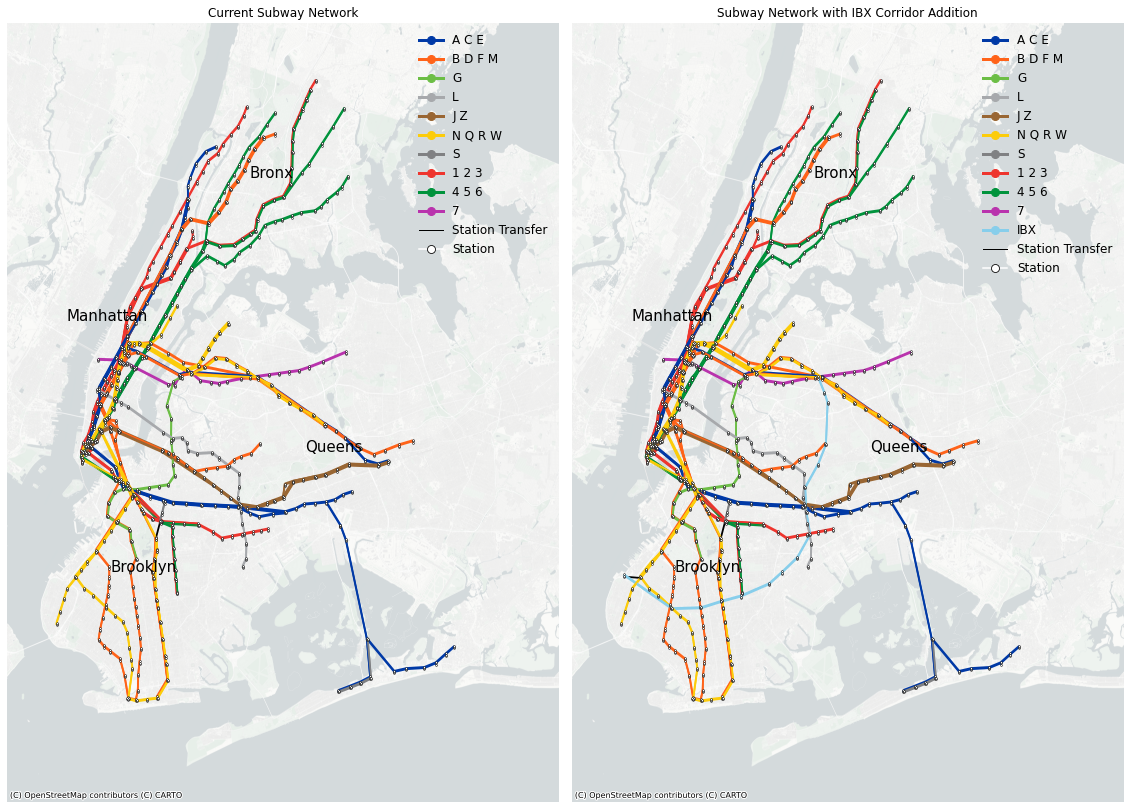

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,20))
ax1.axis('off')
ax2.axis('off')

#plot borough shapefile on both axes
boros_geo.plot( 
    facecolor ='none', 
    edgecolor = 'white', 
    linewidth = 0.1, 
    ax = ax1
    )

boros_geo.plot( 
    facecolor ='none', 
    edgecolor = 'white', 
    linewidth = 0.1, 
    ax = ax2
    )

#annotate boroughs with their name    
boros_geo.apply(
    lambda x: ax1.annotate(
        text = x['boro_name'], 
        xy = x['geometry'].centroid.coords[0], 
        ha = 'right',
        fontsize = 15,
        fontweight = 'medium',
        ), 
    axis = 1
    )
  
boros_geo.apply(
    lambda x: ax2.annotate(
        text = x['boro_name'], 
        xy = x['geometry'].centroid.coords[0], 
        ha = 'right',
        fontsize = 15,
        fontweight = 'medium',
        ), 
    axis = 1
    )

#add basemap from contextily        
ctx.add_basemap(
    ax = ax1, 
    crs = boros_geo.crs.to_string(), 
    source=ctx.providers.CartoDB.PositronNoLabels, #this basemap was chosen due to its clean look, free of ugly labels and highways
    zoom = 15
    )

ctx.add_basemap(
    ax = ax2, 
    crs = boros_geo.crs.to_string(), 
    source=ctx.providers.CartoDB.PositronNoLabels,
    zoom = 15
    )

#draw the network graph on top of basemap
nx.draw(
    subway_now,
    pos=nodePos_proj_now, 
    node_size=3.25, 
    width=1.8, 
    edge_color = line_colors_now, 
    node_color = 'white', 
    edgecolors = 'k', 
    linewidths = 0.5, 
    ax = ax1)

nx.draw(
    subway_ibx,
    pos=nodePos_proj_ibx, 
    node_size=3.25, 
    width=1.8, 
    edge_color = line_colors_ibx, 
    node_color = 'white', 
    edgecolors = 'k', 
    linewidths = 0.5, 
    ax = ax2)

#add legend objects
ax1.legend(legend_lines_now, legend_labels_now, fontsize = 12, frameon = False, loc = 'upper right')
ax2.legend(legend_lines_ibx, legend_labels_ibx, fontsize = 12, frameon = False, loc = 'upper right')

#set titles
ax1.set_title('Current Subway Network', fontsize = 12)
ax2.set_title('Subway Network with IBX Corridor Addition', fontsize = 12)

#adjust subplot spacing
plt.subplots_adjust(wspace=0.025, hspace=0)

#save figure
plt.savefig('network_maps.png', bbox_inches = 'tight', dpi = 300)